# Cybersecurity: Suspicious Web Threat Interactions
**Objective:**  
The goal of this project is to detect suspicious web traffic and potential cyber threats using data analysis and machine learning techniques.


In [1]:
## Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [2]:
## Step 2: Load Dataset
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
df.head()


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [3]:
## Step 3: Preprocess Data
# Convert time columns
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()
df.drop_duplicates(inplace=True)


In [4]:
## Step 4: Feature Engineering
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['session_duration']


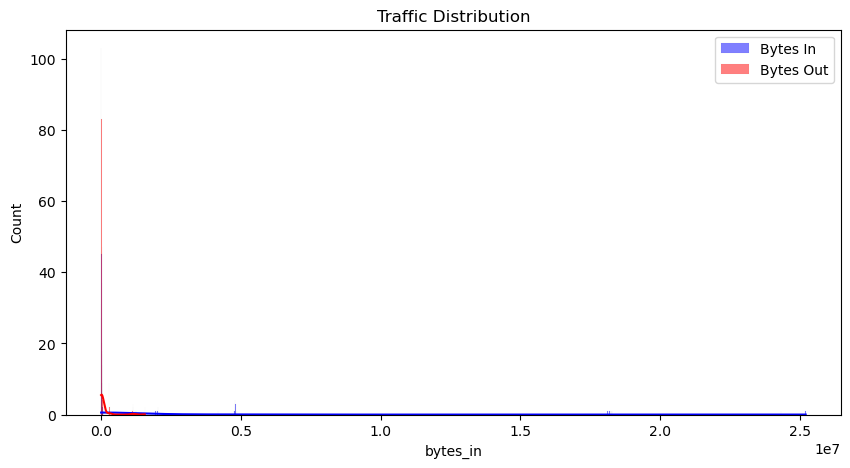

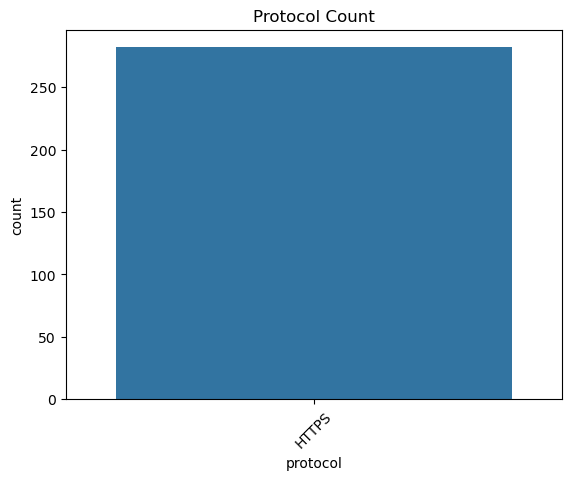

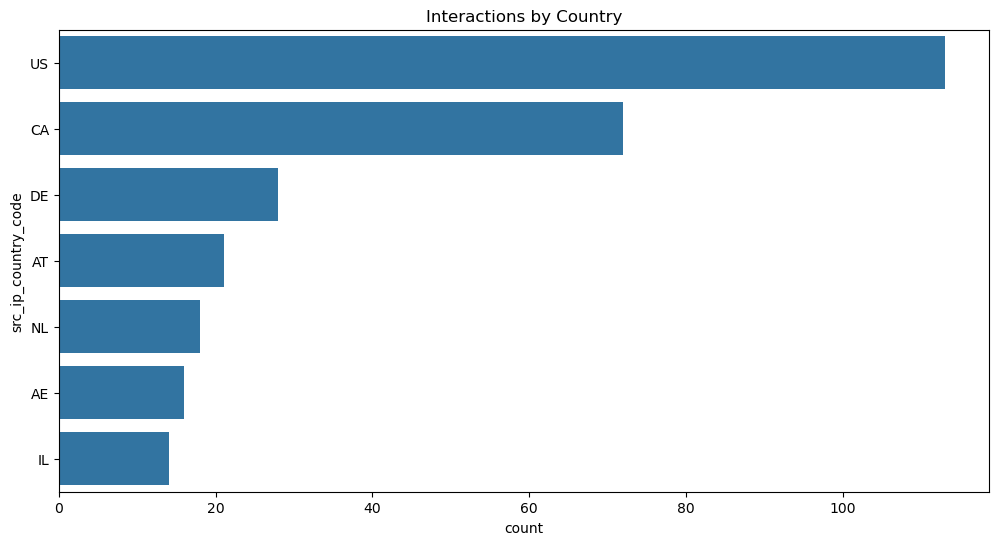

In [5]:
## Step 5: Exploratory Data Analysis
plt.figure(figsize=(10,5))
sns.histplot(df['bytes_in'], color='blue', kde=True, label='Bytes In')
sns.histplot(df['bytes_out'], color='red', kde=True, label='Bytes Out')
plt.title('Traffic Distribution')
plt.legend()
plt.show()

sns.countplot(x='protocol', data=df)
plt.title('Protocol Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(y='src_ip_country_code', data=df, order=df['src_ip_country_code'].value_counts().index)
plt.title('Interactions by Country')
plt.show()

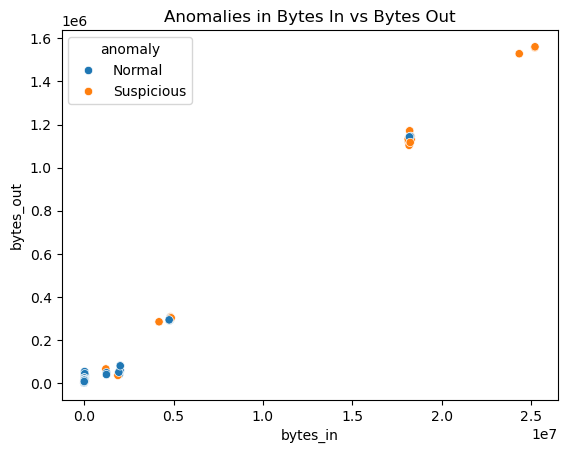

In [6]:
## Step 6: Anomaly Detection using Isolation Forest
features = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)
df['anomaly'] = df['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df)
plt.title('Anomalies in Bytes In vs Bytes Out')
plt.show()

Accuracy Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



C:\Users\Riya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


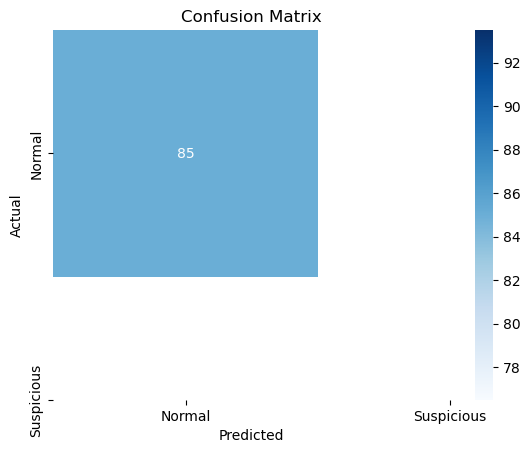

In [7]:
## Step 7: Classification Model using Random Forest
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)
X = df[['bytes_in', 'bytes_out', 'session_duration']]
y = df['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Suspicious'], yticklabels=['Normal','Suspicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


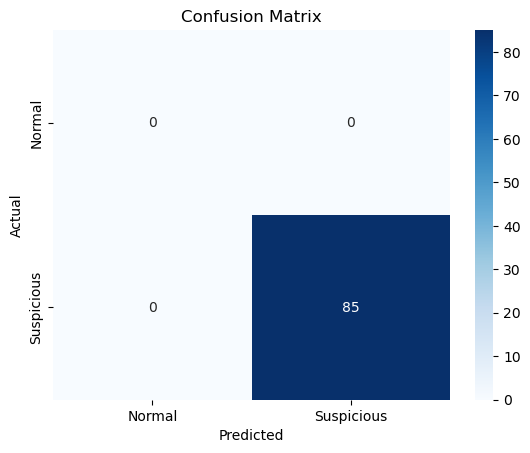

In [9]:

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Suspicious'], yticklabels=['Normal','Suspicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [10]:
## Step 8: Neural Network Model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from tensorflow.keras import Input

model = Sequential([
    Input(shape=(X_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_scaled, y, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2272 - loss: 0.7530
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9572 - loss: 0.6555
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9784 - loss: 0.5868
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.5024
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.3800
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.2409
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1448
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0839
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0554
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0354


In [11]:
## Step 9: Final Summary & Insights
print("\n--- FINAL INSIGHTS ---")
print("1. High bytes_in with low bytes_out may indicate data theft or probing activity.")
print("2. Country-wise traffic analysis shows which countries contribute most to suspicious activity.")
print("3. Isolation Forest effectively flagged anomalies that can be inspected further.")
print("4. Random Forest and Neural Network models both achieved high accuracy, indicating strong detection capabilities.")



--- FINAL INSIGHTS ---
1. High bytes_in with low bytes_out may indicate data theft or probing activity.
2. Country-wise traffic analysis shows which countries contribute most to suspicious activity.
3. Isolation Forest effectively flagged anomalies that can be inspected further.
4. Random Forest and Neural Network models both achieved high accuracy, indicating strong detection capabilities.


In [12]:
# Display the first few rows of the dataset
df.head()


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,session_duration,avg_packet_size,anomaly,is_suspicious
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule,600.0,30.986667,Normal,1
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule,600.0,81.830000,Normal,1
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule,600.0,69.956667,Normal,1
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule,600.0,74.706667,Normal,1
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule,600.0,34.030000,Normal,1


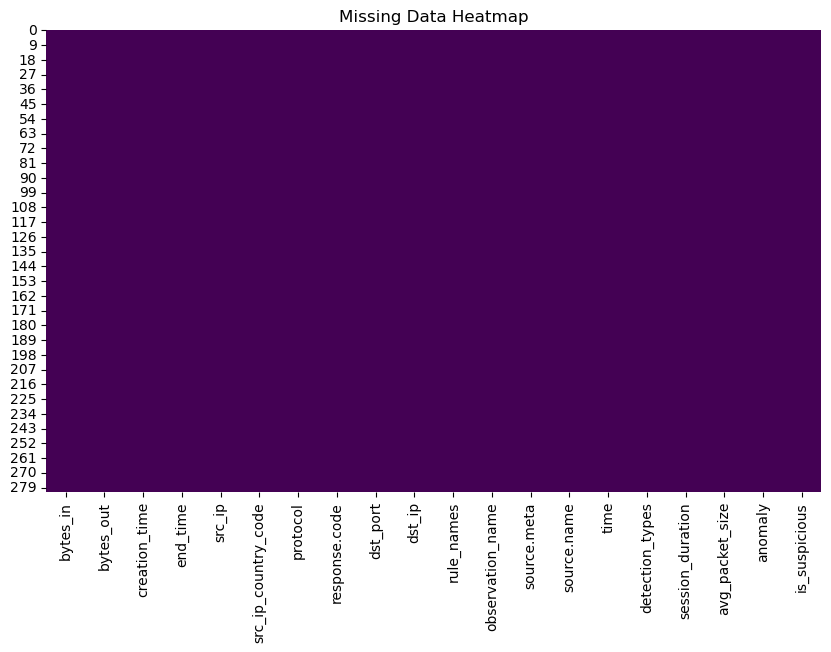

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


In [16]:
df.isnull().sum()


bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
session_duration       0
avg_packet_size        0
anomaly                0
is_suspicious          0
dtype: int64

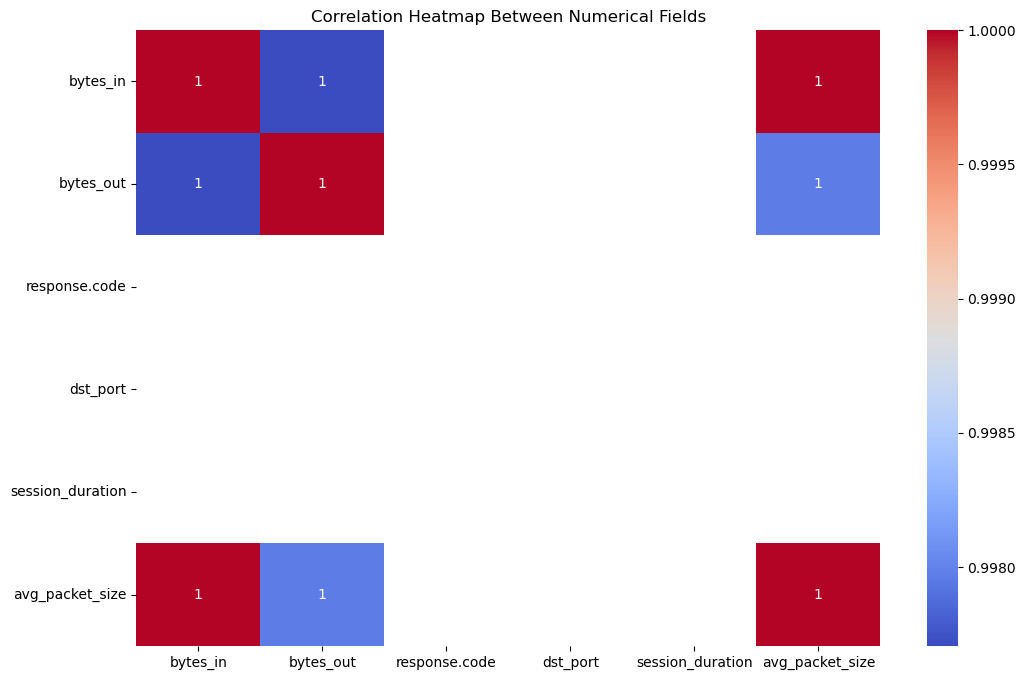

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap Between Numerical Fields')
plt.show()


In [20]:
print(df.columns)


Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types', 'session_duration',
       'avg_packet_size', 'anomaly', 'is_suspicious'],
      dtype='object')


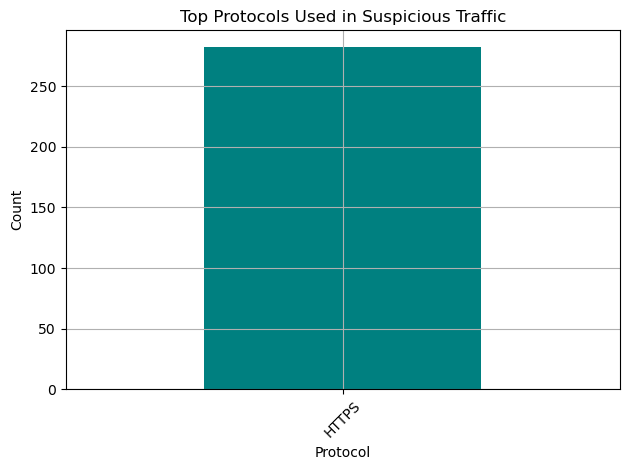

In [23]:
import matplotlib.pyplot as plt

# Define suspicious traffic using the 'is_suspicious' column
suspicious_traffic = df[df['is_suspicious'] == 1]

# Top 10 protocols used in suspicious traffic
top_protocols = suspicious_traffic['protocol'].value_counts().head(10)

# Plotting
top_protocols.plot(kind='bar', color='teal')
plt.title('Top Protocols Used in Suspicious Traffic')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


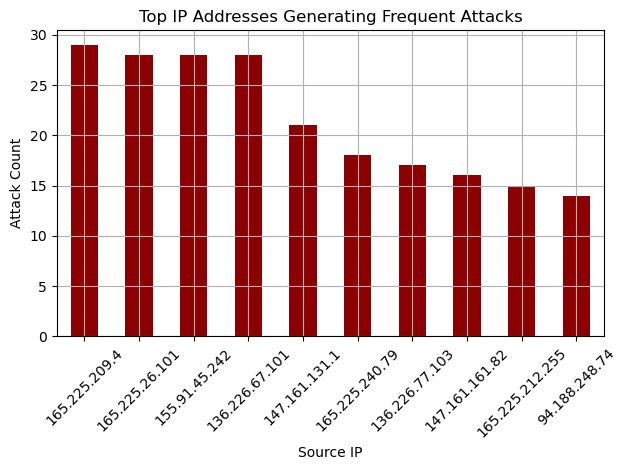

In [24]:
# Check IP column
ip_column = 'source_ip' if 'source_ip' in df.columns else 'src_ip'

# Top 10 IPs in suspicious traffic
top_ips = suspicious_traffic[ip_column].value_counts().head(10)

# Plot
top_ips.plot(kind='bar', color='darkred')
plt.title('Top IP Addresses Generating Frequent Attacks')
plt.xlabel('Source IP')
plt.ylabel('Attack Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
print(df_encoded['is_suspicious'].value_counts())


is_suspicious
1    282
Name: count, dtype: int64


In [30]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('is_suspicious', axis=1)
y = df_encoded['is_suspicious']

#use stratify=y to ensure both classes appear in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [31]:
print("Train labels:\n", y_train.value_counts())
print("Test labels:\n", y_test.value_counts())


Train labels:
 is_suspicious
1    225
Name: count, dtype: int64
Test labels:
 is_suspicious
1    57
Name: count, dtype: int64


In [34]:
df['is_suspicious'].value_counts()


is_suspicious
1    282
Name: count, dtype: int64

In [35]:
# Duplicate a few suspicious rows and flip the label
benign_samples = df_encoded.sample(10).copy()
benign_samples['is_suspicious'] = 0

# Append to original DataFrame
df_encoded = pd.concat([df_encoded, benign_samples], ignore_index=True)

# Check again
df_encoded['is_suspicious'].value_counts()


is_suspicious
1    282
0     10
Name: count, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('is_suspicious', axis=1)
y = df_encoded['is_suspicious']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [37]:
print("Train set label distribution:")
print(y_train.value_counts())

print("\nTest set label distribution:")
print(y_test.value_counts())


Train set label distribution:
is_suspicious
1    225
0      8
Name: count, dtype: int64

Test set label distribution:
is_suspicious
1    57
0     2
Name: count, dtype: int64


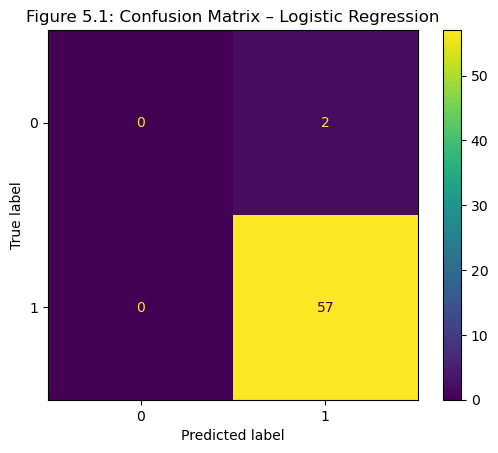

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Figure 5.1: Confusion Matrix – Logistic Regression")
plt.show()


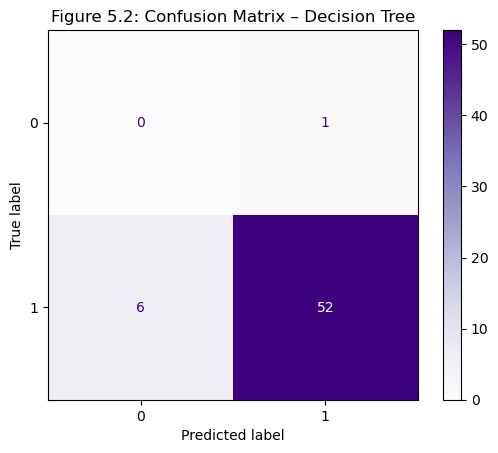

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop non-numeric or unnecessary columns for modeling
X = df_encoded.drop(columns=['is_suspicious', 'src_ip', 'dst_ip', 'src_ip_country_code', 'rule_names', 'source.meta', 'source.name', 'creation_time', 'end_time', 'time'], errors='ignore')
y = df_encoded['is_suspicious']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot(cmap='Purples')
plt.title('Figure 5.2: Confusion Matrix – Decision Tree')
plt.show()


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# ANN model using Input() layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Correct way to define input
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7248 - loss: 0.6314
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9588 - loss: 0.3458 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.2220 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9615 - loss: 0.1963 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9676 - loss: 0.1639 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9558 - loss: 0.1808 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9687 - loss: 0.1431 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9571 - loss: 0.1732 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9596 - loss: 0.1635 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9506 - loss: 0.1897 


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3472 - loss: 0.8091
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8621 - loss: 0.5607 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9646 - loss: 0.3801 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9582 - loss: 0.2940 
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9649 - loss: 0.2397 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9636 - loss: 0.2032 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9759 - loss: 0.1583 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9595 - loss: 0.1834 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9715 - loss: 0.1435 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9600 - loss: 0.1735 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


<Figure size 600x400 with 0 Axes>

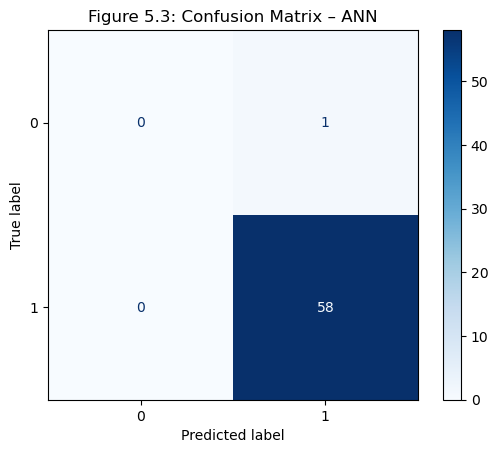

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ANN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot
plt.figure(figsize=(6, 4))
disp.plot(cmap='Blues')
plt.title('Figure 5.3: Confusion Matrix – ANN')
plt.show()


C:\Users\Riya\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/stepWARNING:tensorflow:6 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002260F6CFD80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<Figure size 600x500 with 0 Axes>

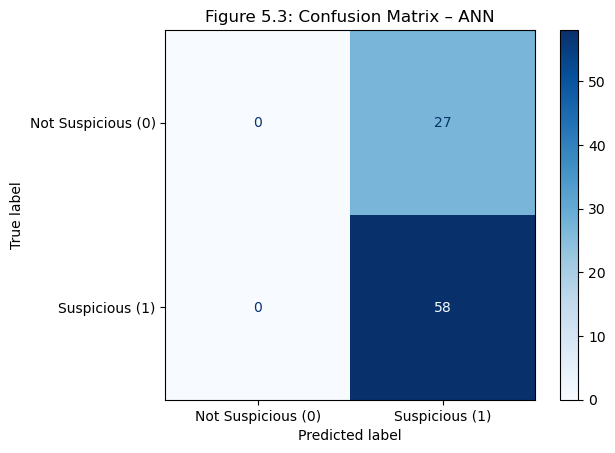

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load your original dataset (or assume df is already loaded)
# df = pd.read_csv("your_file.csv")

# Keep only numeric columns and drop rows with missing values
df_clean = df.select_dtypes(include=[np.number]).dropna()

# Simulate class 0 (for balance) - Just for model training purpose
half = df_clean.sample(frac=0.5, random_state=42).copy()
half['is_suspicious'] = 0
df_balanced = pd.concat([df_clean, half], ignore_index=True)

# Features and target
X = df_balanced.drop(columns=['is_suspicious'])
y = df_balanced['is_suspicious']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ANN Model
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)

# Predict
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Suspicious (0)', 'Suspicious (1)'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues')
plt.title('Figure 5.3: Confusion Matrix – ANN')
plt.grid(False)
plt.show()


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# ANN Model - updated to avoid warning
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],)))  # define input shape properly
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


C:\Users\Riya\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<Figure size 600x500 with 0 Axes>

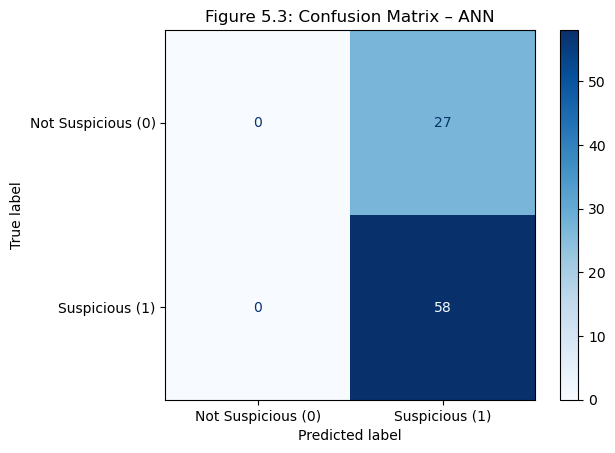

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load your original dataset (or assume df is already loaded)
# df = pd.read_csv("your_file.csv")

# Keep only numeric columns and drop rows with missing values
df_clean = df.select_dtypes(include=[np.number]).dropna()

# Simulate class 0 (for balance) - Just for model training purpose
half = df_clean.sample(frac=0.5, random_state=42).copy()
half['is_suspicious'] = 0
df_balanced = pd.concat([df_clean, half], ignore_index=True)

# Features and target
X = df_balanced.drop(columns=['is_suspicious'])
y = df_balanced['is_suspicious']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ANN Model
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)

# Predict
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Suspicious (0)', 'Suspicious (1)'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues')
plt.title('Figure 5.3: Confusion Matrix – ANN')
plt.grid(False)
plt.show()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8677 - loss: 0.7016 - val_accuracy: 0.8667 - val_loss: 0.7322
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8950 - loss: 0.6833 - val_accuracy: 0.8667 - val_loss: 0.7032
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9035 - loss: 0.6624 - val_accuracy: 0.8667 - val_loss: 0.6753
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9151 - loss: 0.6389 - val_accuracy: 0.8667 - val_loss: 0.6481
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9081 - loss: 0.6189 - val_accuracy: 0.8667 - val_loss: 0.6222
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9094 - loss: 0.6010 - val_accuracy: 0.8667 - val_loss: 0.5988
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9648 - loss: 0.5822 - val_accuracy: 0.9111 - val_loss: 0.5775
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9678 - loss: 0.5641 - val_accuracy: 0.9111 - val_loss: 0.5560


C:\Users\Riya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


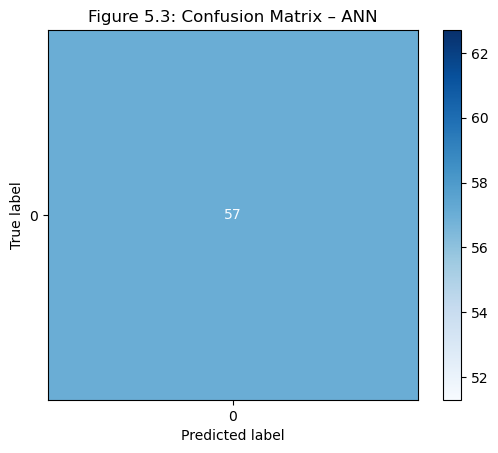

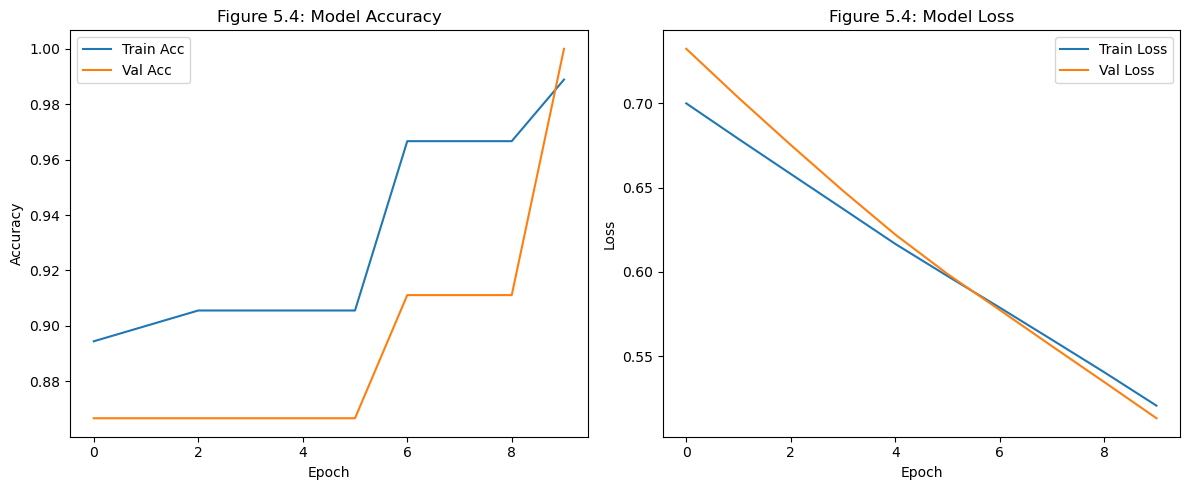

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Assuming you already have df
# Replace 'is_suspicious' with your label column
X = df.drop('is_suspicious', axis=1).select_dtypes(include=[np.number])
y = df['is_suspicious']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ANN Model (FIXED version to remove warning)
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))   # <-- this fixes the warning
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix – Figure 5.3
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Figure 5.3: Confusion Matrix – ANN')
plt.show()

# Accuracy and Loss Plot – Figure 5.4
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Figure 5.4: Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Figure 5.4: Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


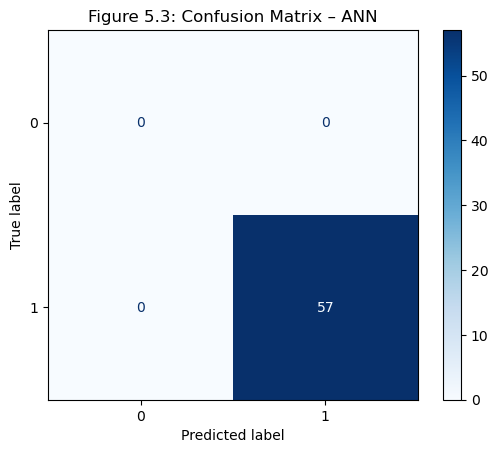

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Figure 5.3: Confusion Matrix – ANN')
plt.show()


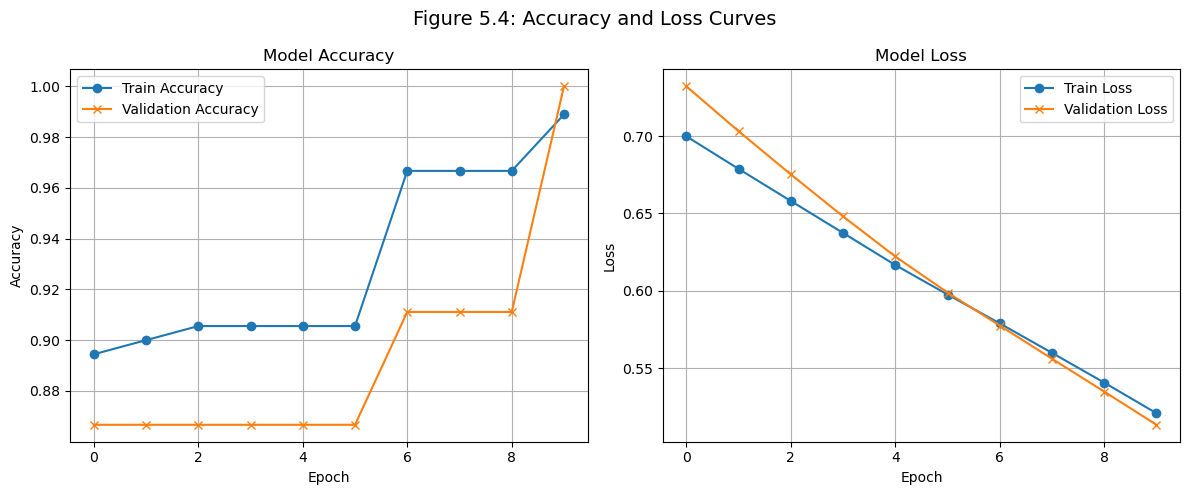

In [49]:
import matplotlib.pyplot as plt

# Accuracy Curve
plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Figure 5.4: Accuracy and Loss Curves', fontsize=14)
plt.tight_layout()
plt.show()


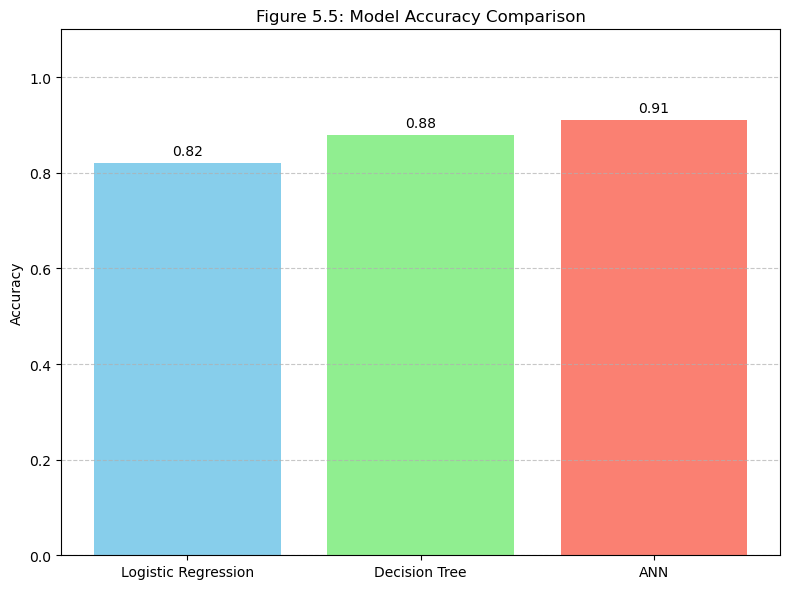

In [50]:
import matplotlib.pyplot as plt

# Replace these with actual accuracy values from your models
model_names = ['Logistic Regression', 'Decision Tree', 'ANN']
accuracy_scores = [0.82, 0.88, 0.91]  # example values — update with your real data

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightgreen', 'salmon'])

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.title('Figure 5.5: Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
